# Lookup Table Interpolation
We use a lookup table (LUT) to estimate the value of T1 from an MP2RAGE sequence.

In [8]:
import os
import json
import nibabel as nib
from nilearn import plotting
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import LinearNDInterpolator
from sklearn.metrics import mean_squared_error
import t1_mapping

# Change plot style
plt.style.use('Solarize_Light2')

# Load data
We load the given data from an example MP2RAGE sequence.

In [2]:
# Load dataset paths
subject = '334264'
scan = '401-x-WIPMP2RAGE_0p7mm_1sTI_best_oneSENSE-x-WIPMP2RAGE_0p7mm_1sTI_best_oneSENSE'
scan_num = '401'
scan_times = ['1010', '3310', '5610']
dataset_path = '/nfs/masi/saundam1/outputs/mp2rage_converted_v2023/'
subject_path = os.path.join(dataset_path, subject, scan)

# Load NIFTI files
inv1_real = nib.load(os.path.join(subject_path, f'{scan_num}_real_t{scan_times[0]}.nii'))
inv1_imag = nib.load(os.path.join(subject_path, f'{scan_num}_imaginary_t{scan_times[0]}.nii'))
inv2_real = nib.load(os.path.join(subject_path, f'{scan_num}_realsorted_idx = np.argsort(MP2RAGE)
MP2RAGE = MP2RAGE[sorted_idx]
t1_estimate = t1_estimate[sorted_idx]
inv1_json_path = os.path.join(subject_path, f'{scan_num}_t{scan_times[0]}.json')
inv2_json_path = os.path.join(subject_path, f'{scan_num}_t{scan_times[1]}.json')
inv3_json_path = os.path.join(subject_path, f'{scan_num}_t{scan_times[2]}.json')
with open(inv1_json_path, 'r') as f1, open(inv2_json_path, 'r') as f2, open(inv3_json_path, 'r') as f3:
    inv1_json = json.load(f1)
    inv2_json = json.load(f2)
    inv3_json = json.load(f3)

# Load data from NIFTI
inv1_real_data = inv1_real.get_fdata()
inv1_imag_data = inv1_imag.get_fdata()
inv2_real_data = inv2_real.get_fdata()
inv2_imag_data = inv2_imag.get_fdata()
inv3_real_data = inv3_real.get_fdata()
inv3_imag_data = inv3_imag.get_fdata()

# Create combined complex data
inv1_data = inv1_real_data + 1j*inv1_imag_data
inv2_data = inv2_real_data + 1j*inv2_imag_data
inv3_data = inv3_real_data + 1j*inv3_imag_data

# Create NIFTIs
inv1 = nib.nifti1.Nifti1Image(inv1_data, inv1_real.affine)
inv2 = nib.nifti1.Nifti1Image(inv2_data, inv2_real.affine)
inv3 = nib.nifti1.Nifti1Image(inv3_data, inv3_real.affine)

## Get acquisition parameters

In [3]:
# Load acquisition parameters
params : t1_mapping.utils.MP2RAGEParameters = {
    "MP2RAGE_TR": 8.25,
    "TR": inv1_json["RepetitionTime"],
    "flip_angles": [inv1_json['FlipAngle'], inv2_json['FlipAngle'], inv3_json['FlipAngle']],
    "inversion_times": [inv1_json['TriggerDelayTime']/1000, inv2_json['TriggerDelayTime']/1000, inv3_json['TriggerDelayTime']/1000],
    "n": [225],
    "eff": 0.84,
}

## Plot T1-weighted image
Now, we plot the T1-weighted image calculated from the gradient echo readouts.

Text(0.5, 1.0, 'T1-Weighted Image')

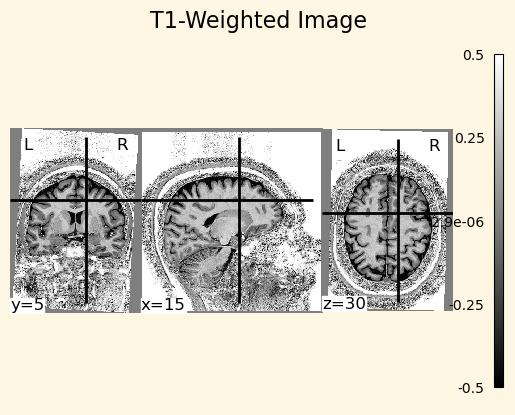

In [4]:
# Calculate MP2RAGE image
t1w = t1_mapping.utils.mp2rage_t1w(inv1_data, inv2_data)
t1w_nifti = nib.nifti1.Nifti1Image(t1w, inv1_real.affine)

# Plot T1w image
fig, ax = plt.subplots()
plotting.plot_img(t1w_nifti, cut_coords=(15, 5, 30), cmap='gray', axes=ax, colorbar=True)
ax.set_title('T1-Weighted Image')

# Create LUT
Next, we calculate the values for the LUT given the provided parameters and an estimate of the t-values.

In [5]:
# Range of values for T1
t1_estimate = np.arange(0.05, 5.01, 0.05)
num_points = len(t1_estimate)

# Get equation parameters
eqn_params = t1_mapping.utils.acq_to_eqn_params(params)

# Calculate what values would be produced using these parameters
GRE = t1_mapping.utils.gre_signal(T1=t1_estimate, **eqn_params)

## Plot GRE estimates
These functions should appear smooth. If there are any outliers, it will affect the T1 mapping.

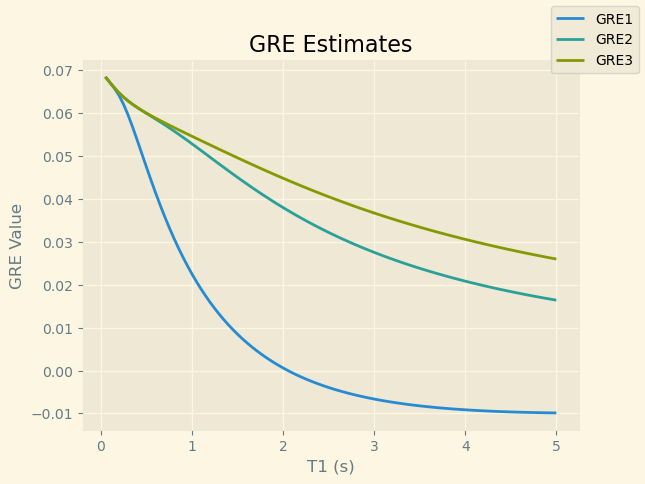

In [6]:
fig, ax = plt.subplots()
ax.plot(t1_estimate, GRE[0,:], label="GRE1")
ax.plot(t1_estimate, GRE[1,:], label="GRE2")
ax.plot(t1_estimate, GRE[2,:], label="GRE3")
ax.set_title('GRE Estimates')
ax.set_xlabel("T1 (s)")
ax.set_ylabel("GRE Value")
fig.legend()

# Calculate $t$ map using LUT
Finally, we can calculate values for $t$ by interpolating between the values on our LUT.

In [15]:
# Calculate for desired values
interp = RegularGridInterpolator((GRE[0,:], GRE[1,:], GRE[2,:]), t1_estimate)
# pts = 

# t1_calc = np.interp(t1w.flatten(), MP2RAGE, t1_estimate, right=0.)
# t1_calc = t1_calc.reshape(t1w.shape)

# # Create NIFTI
# t1_calc_nifti = nib.nifti1.Nifti1Image(t1_calc, inv1_real.affine)

# # Plot T1 map image
# fig, ax = plt.subplots()
# plotting.plot_img(t1_calc_nifti, cut_coords=(15, 5, 30), cmap='gray', axes=ax, colorbar=True, vmin=0, vmax=5)
# ax.set_title('T1 Map (mine)')

(100,)


ValueError: There are 3 point arrays, but values has 1 dimensions

## Compare to Marques et al.

Text(0.5, 1.0, 'T1 Map (Marques et al.)')

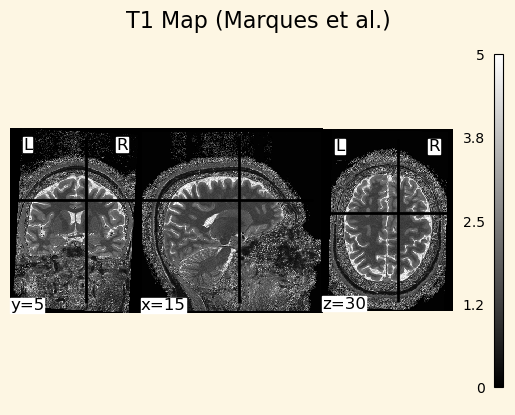

In [ ]:
# Plot T1 map from Marques repo
t1_marques = nib.load('/home/local/VANDERBILT/saundam1/Documents/MP2RAGE-related-scripts/example_t1map2.nii')
t1_marques_data = t1_marques.get_fdata()
fig, ax = plt.subplots()
plotting.plot_img(t1_marques, cut_coords=(15, 5, 30), cmap='gray', axes=ax, colorbar=True, vmin=0, vmax=5)
ax.set_title('T1 Map (Marques et al.)')

RMSE=5.608963989234462e-14


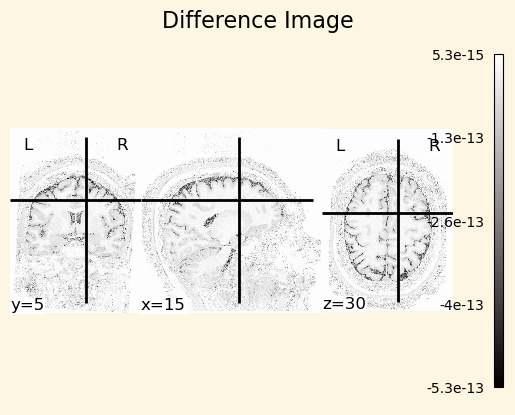

In [ ]:
# Plot difference image
t1_diff = t1_calc - t1_marques.get_fdata()
t1_diff_nifti = nib.nifti1.Nifti1Image(t1_diff, inv1_real.affine)
fig, ax = plt.subplots()
plotting.plot_img(t1_diff_nifti, cut_coords=(15, 5, 30), cmap='gray', axes=ax, colorbar=True)
ax.set_title('Difference Image')

# Calculate RMSE
t_lin = t1_marques.get_fdata().flatten()
t_calc_lin = t1_calc.flatten()
RMSE = mean_squared_error(t_lin, t_calc_lin, squared=False)
print(f'{RMSE=}')

## Save all NIFTIs

In [ ]:
# t1_calc_nifti.to_filename('outputs/example_t1_map.nii')
# t1_marques.to_filename('outputs/example_t1_map_marques.nii')
# t1_diff_nifti.to_filename('outputs/example_t1_map_diff.nii')